# Sentiment Analysis in Python

This notebook is part of a tutorial that can be found on my [youtube channel here](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw), please check it out!

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [1]:
import os

In [ ]:
%pwd

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# Read in data
#df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
df = pd.read_csv('artifacts\data_ingestion\mobile_phone_data.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(23777, 5)
(500, 5)


In [3]:
df["rating_num"] = df["rating"].apply(lambda x: float(x.split()[0]))

In [4]:
df = df.drop(df.columns[0], axis=1)

df.insert(0, 'Id', range(1, 1 + len(df)))

In [5]:
df.head()

,Id,Review-Title,rating,Review-Body,Product Name,rating_num
0,1,Worst phone ever,1.0 out of 5 stars,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0
1,2,Ok !!! Not up to the mark,2.0 out of 5 stars,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2.0
2,3,Awesome look,5.0 out of 5 stars,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5.0
3,4,One plus losing is originality!!!,3.0 out of 5 stars,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3.0
4,5,Read,1.0 out of 5 stars,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0


## Quick EDA

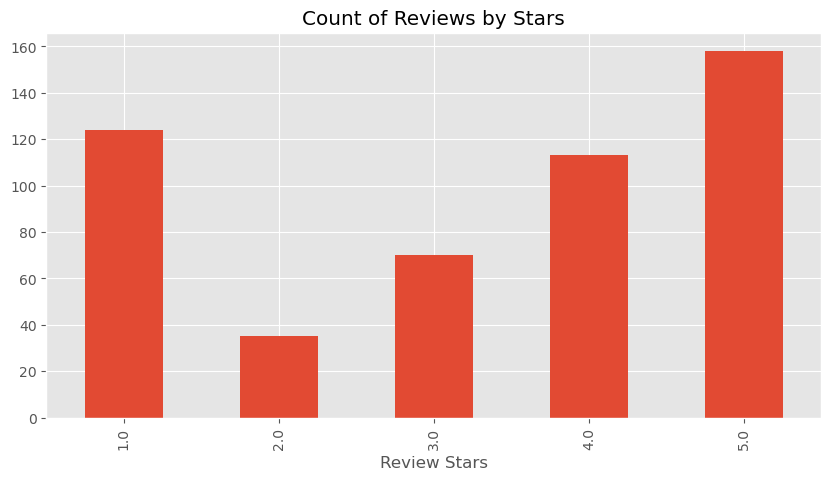

In [6]:
ax = df['rating_num'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [7]:
example = df['Review-Body'][50]
print(example)

The media could not be loaded.
                



 Like it


In [8]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['The', 'media', 'could', 'not', 'be', 'loaded', '.', 'Like', 'it']

In [9]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('The', 'DT'),
 ('media', 'NNS'),
 ('could', 'MD'),
 ('not', 'RB'),
 ('be', 'VB'),
 ('loaded', 'VBN'),
 ('.', '.'),
 ('Like', 'IN'),
 ('it', 'PRP')]

In [10]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  The/DT
  media/NNS
  could/MD
  not/RB
  be/VB
  loaded/VBN
  ./.
  Like/IN
  it/PRP)


# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [12]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [13]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [14]:
sia.polarity_scores(example)

{'neg': 0.232, 'neu': 0.768, 'pos': 0.0, 'compound': -0.2755}

In [15]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['Review-Body'])
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [17]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,Review-Title,rating,Review-Body,Product Name,rating_num
0,1,0.730,0.270,0.000,-0.4019,Worst phone ever,1.0 out of 5 stars,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0
1,2,0.123,0.808,0.069,-0.6019,Ok !!! Not up to the mark,2.0 out of 5 stars,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2.0
2,3,0.012,0.767,0.221,0.9872,Awesome look,5.0 out of 5 stars,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5.0
3,4,0.040,0.759,0.200,0.9789,One plus losing is originality!!!,3.0 out of 5 stars,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3.0
4,5,0.054,0.865,0.081,0.2846,Read,1.0 out of 5 stars,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0


## Plot VADER results

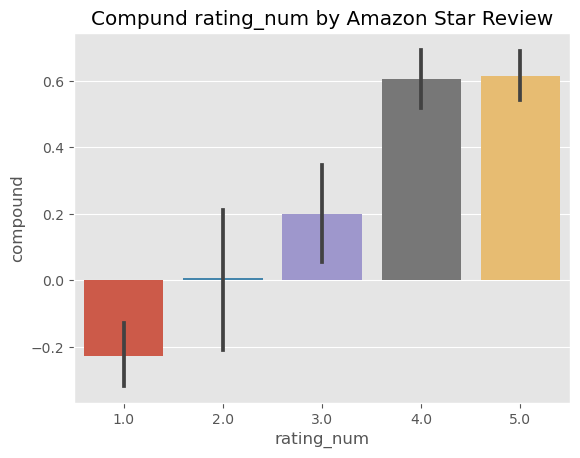

In [18]:
ax = sns.barplot(data=vaders, x='rating_num', y='compound')
ax.set_title('Compund rating_num by Amazon Star Review')
plt.show()

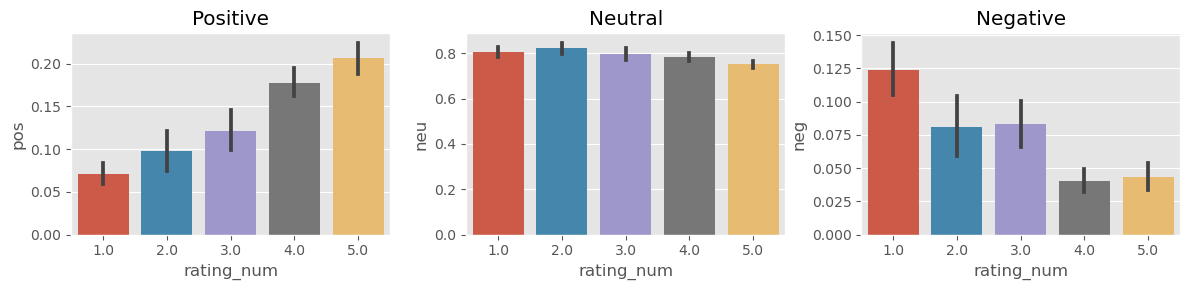

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating_num', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating_num', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating_num', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [20]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [21]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [22]:
# VADER results on example
print(example)
sia.polarity_scores(example)

The media could not be loaded.
                



 Like it


{'neg': 0.232, 'neu': 0.768, 'pos': 0.0, 'compound': -0.2755}

In [23]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.46967116, 'roberta_neu': 0.43303636, 'roberta_pos': 0.09729245}


In [24]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [25]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = str(row['Review-Body'])
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 7
Broke for id 13
Broke for id 18
Broke for id 29
Broke for id 131


In [26]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [27]:
results_df.head(3)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Review-Title,rating,Review-Body,Product Name,rating_num
0,1,0.730,0.270,0.000,-0.4019,0.369169,0.570488,0.060343,Worst phone ever,1.0 out of 5 stars,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0
1,2,0.123,0.808,0.069,-0.6019,0.395395,0.454795,0.149810,Ok !!! Not up to the mark,2.0 out of 5 stars,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2.0
2,3,0.012,0.767,0.221,0.9872,0.001653,0.021798,0.976549,Awesome look,5.0 out of 5 stars,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5.0


In [28]:
import torch.nn.functional as F
import torch

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output.logits[0]
    predicted_class = torch.argmax(F.softmax(scores, dim=-1)).item()
    
    # Convert three classes to two classes (positive or negative)
    is_positive = predicted_class == 2
    scores_dict = {
        'roberta_positive': 1.0 if is_positive else 0.0,
        'roberta_negative': 1.0 if not is_positive else 0.0
    }
    return scores_dict

res2 = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = str(row['Review-Body'])
        texts = text.split(".")
        myid = row['Id']
        
        # Roberta sentiment analysis
        for text in texts:
            roberta_result = polarity_scores_roberta(text)
        
        # Combine both results
        both = {**vader_result_rename, **roberta_result}
        
        res2[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')


  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 7
Broke for id 13
Broke for id 18
Broke for id 29
Broke for id 131


In [29]:
results_df = pd.DataFrame(res2).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [31]:
results_df.head(10)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_positive,roberta_negative,Review-Title,rating,Review-Body,Product Name,rating_num
0,1,0.730,0.270,0.000,-0.4019,0.0,1.0,Worst phone ever,1.0 out of 5 stars,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0
1,2,0.123,0.808,0.069,-0.6019,0.0,1.0,Ok !!! Not up to the mark,2.0 out of 5 stars,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2.0
2,3,0.012,0.767,0.221,0.9872,1.0,0.0,Awesome look,5.0 out of 5 stars,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5.0
3,4,0.040,0.759,0.200,0.9789,1.0,0.0,One plus losing is originality!!!,3.0 out of 5 stars,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3.0
4,5,0.054,0.865,0.081,0.2846,1.0,0.0,Read,1.0 out of 5 stars,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0
5,6,0.020,0.788,0.192,0.9588,1.0,0.0,Fantastic but some bug fixes required!,4.0 out of 5 stars,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",4.0
6,8,0.138,0.622,0.240,0.3546,0.0,1.0,Camera is not good... oppo is the best,3.0 out of 5 stars,Phone is over all good but some heating proble...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3.0
7,9,0.071,0.802,0.127,0.8936,0.0,1.0,****VERY DISPOINTED BY 1PLUS****. Sound and ba...,1.0 out of 5 stars,****Don't buy any phones from Amazon*** i real...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0
8,10,0.000,0.865,0.135,0.8624,1.0,0.0,Excellent all rounder!,5.0 out of 5 stars,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5.0
9,11,0.000,1.000,0.000,0.0000,0.0,1.0,bakwas mobile hai,1.0 out of 5 stars,bakwas mobile hai,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0


## Compare Scores between models

In [32]:
results_df.tail()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_positive,roberta_negative,Review-Title,rating,Review-Body,Product Name,rating_num
490,496,0.000,1.000,0.000,0.0000,0.0,1.0,"Don't believe review,all are cheap, waste of m...",1.0 out of 5 stars,"Battery drain very fast, not more than 3hr net...","OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0
491,497,0.053,0.947,0.000,-0.1419,0.0,1.0,I brought this product on 30 March 22 but with...,1.0 out of 5 stars,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0
492,498,0.134,0.826,0.039,-0.6808,0.0,1.0,Not on OnePlus level 👎,2.0 out of 5 stars,Though it's a mid range phone for 5g it never ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2.0
493,499,0.084,0.728,0.188,0.7604,1.0,0.0,An average Phone!,3.0 out of 5 stars,"a decent phone, with everything just average n...","OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3.0
494,500,0.266,0.691,0.043,-0.8999,0.0,1.0,Not worth 25k,2.0 out of 5 stars,Fingerprint quality and charging speed is good...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2.0


In [38]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Review-Title', 'rating',
       'Review-Body', 'Product Name', 'rating_num'],
      dtype='object')

# Step 3. Combine and compare

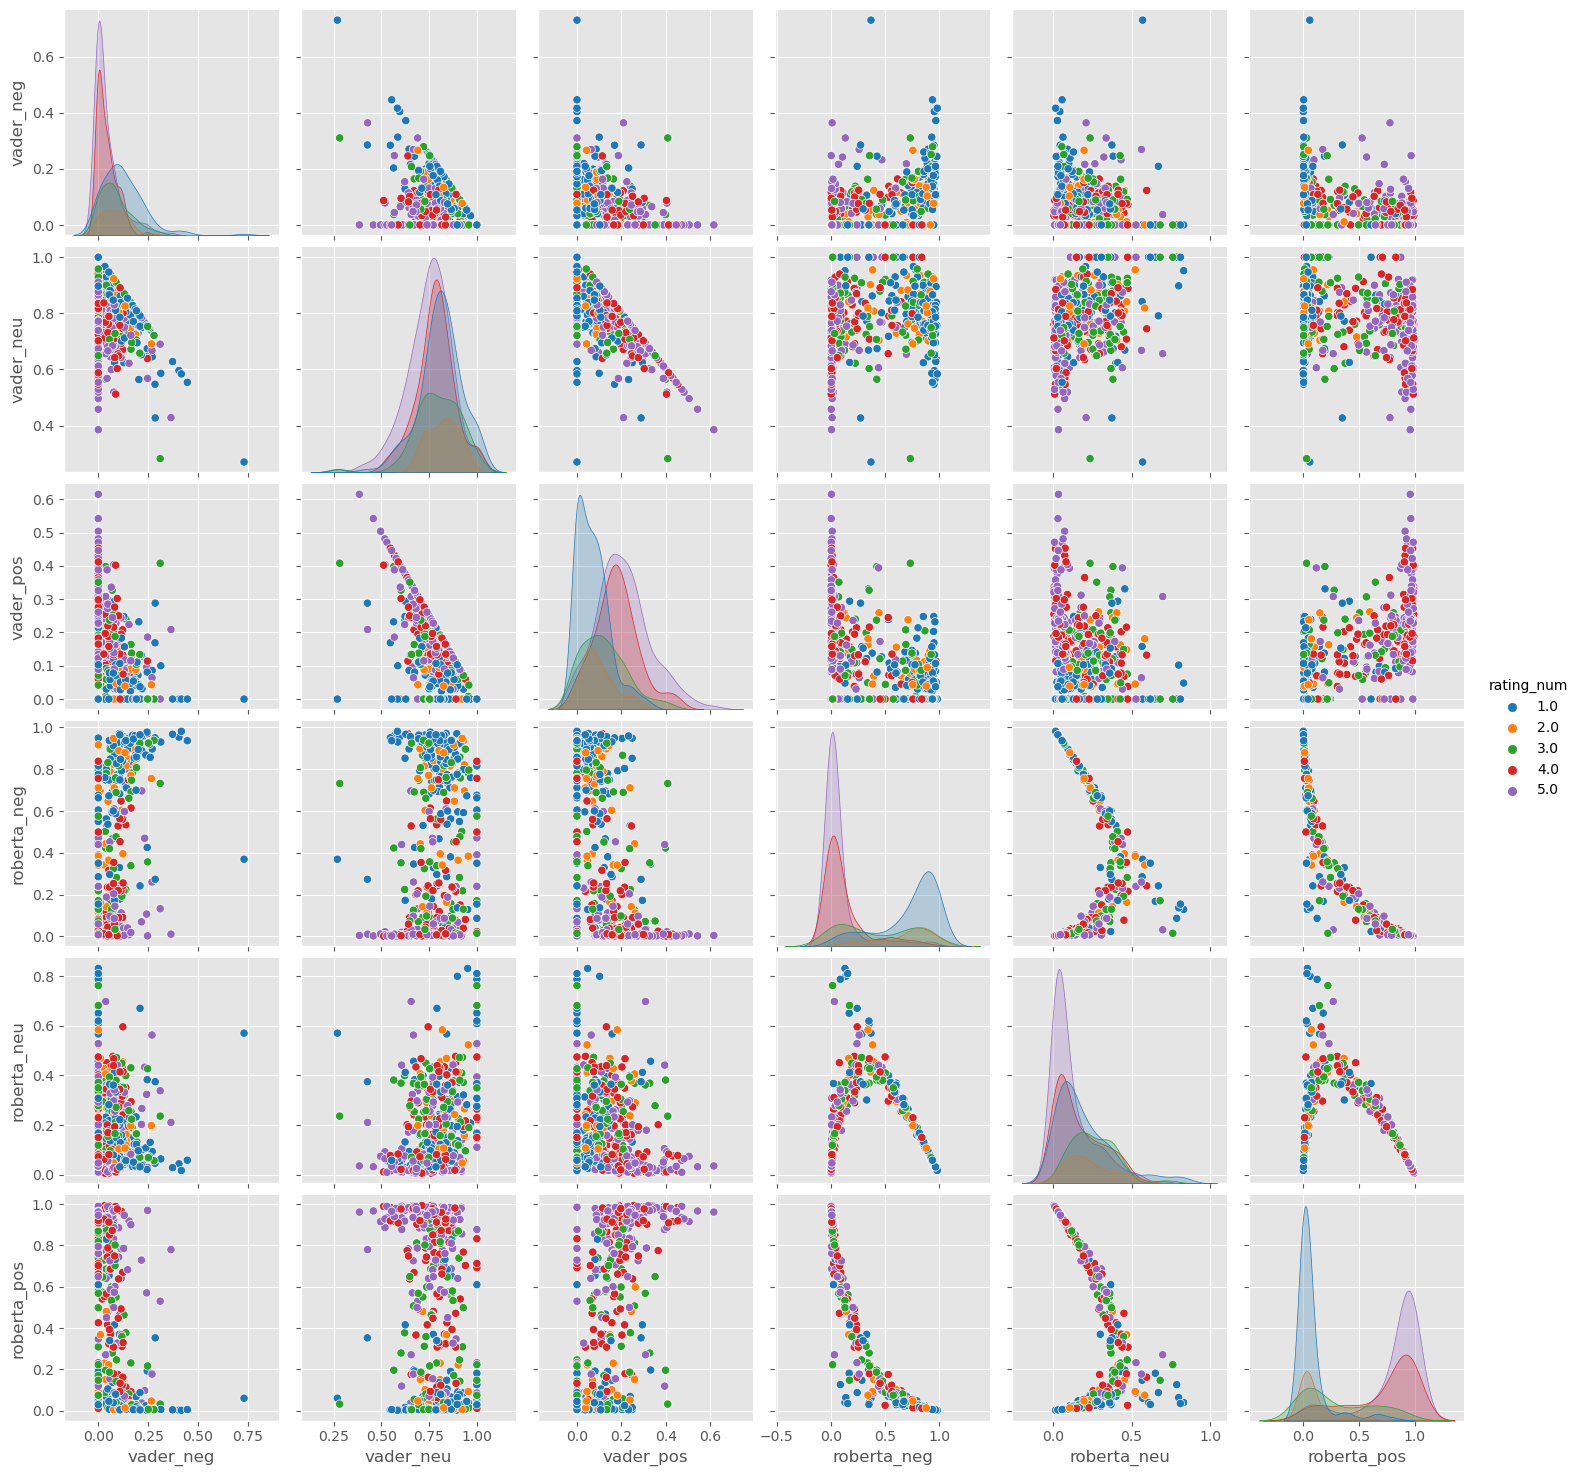

In [39]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='rating_num',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [42]:
results_df.query('rating_num == 1') \
    .sort_values('roberta_pos', ascending=False)['Review-Body'].values[0]

"I'm writing this review after using the phone about 2 weeks..It's not like other OnePlus  Camera quality..  Battery 🔋 backup  of the phone is same like my previous phone( i used my phone not 5 pro approx 6 years but battery is still better than this phone and most importantly never heat up after so many years nd ) ... this phone is heat up very fast after continuous using the phone 1 hrs .. not upto the rate.."

In [44]:
results_df.query('rating_num == 1') \
    .sort_values('vader_pos', ascending=False)['Review-Body'].values[0]

"The media could not be loaded.\n                \n\n\n\n\xa0Any thing is best but camera is good pls Don't but this product"

In [30]:
# nevative sentiment 5-Star view

In [31]:
results_df.query('rating_num == 5') \
    .sort_values('roberta_neg', ascending=False)['Review-Body'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [32]:
results_df.query('rating_num == 5') \
    .sort_values('vader_neg', ascending=False)['Review-Body'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [33]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [34]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [35]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [36]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

# The End